In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit 
from astropy.io import fits
import corner
from IPython.display import Latex
import sys
import warnings
import tqdm


plt.rcParams['image.cmap'] = 'Blues'
warnings.filterwarnings("ignore")

imageFile = "../fit/agn.fits"
imageAGN = fits.getdata(imageFile)

epsf = fits.getdata("../psfConstruction/epsf2.fits")

In [2]:
def find_highest_indices(arr):
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices


def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim,
                 PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim, sigma_lim, Iss_lim, rss_lim):
    """create galaxy model for ML fit
        including: ps: 1 psf + 1 sersic
                   psps: 2 psf + 2 sersic"""

    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    
    psf = {'I_tot' : Itot}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}

    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_sersic0 = {'X0': [Xss0,Xlim[0],Xlim[1]], 'Y0': [Yss0,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xlim[0],Xlim[1]], 'Y0': [Yss1,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict, sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict, sersic_dict]}

    
    model_dict_ps_1c = {'function_sets': [funcset_dict_psfser0]}
    model_dict_psps_1c = {'function_sets': [funcset_dict_psfser0,funcset_dict_psfser1]}
    
    model_dict_ps_2c = {'function_sets': [funcset_dict_psf0,funcset_dict_sersic0]}
    model_dict_psps_2c = {'function_sets': [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1]}
    
    model_ps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_1c)
    model_psps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_1c)
    model_ps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_2c)
    model_psps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_2c)
    return model_ps1c, model_psps1c, model_ps2c, model_psps2c



def doFit(models,epsf): 
    """do fit with data using PSF oversampled by factor of 4 over whole image
       return fitters"""
    fitters = []
    # oversamped PSF
    psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (0,100,0,100))
    osampleList = [psfOsamp]
    for i in tqdm.tqdm(range(len(models)), desc="Fitting Models"):
        imfit_fitter = pyimfit.Imfit(models[i],psf=epsf)
        imfit_fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
        imfit_fitter.doFit()
        fitters.append(imfit_fitter)
    return fitters



        
        
starpos = find_highest_indices(imageAGN)
center = (starpos[0]+starpos[1])/2
Imax = imageAGN.max()
itot=epsf.sum()


X0=starpos[0][0]
Y0=starpos[0][1]
X1=starpos[1][0]
Y1=starpos[1][1] 
Xss0=starpos[0][0]
Yss0=starpos[0][1]
Xss1=starpos[1][0]
Yss1=starpos[1][1]
Xlim=[0,100]
Ylim=[0,100]
PA_ss=200
ell_ss=0.1
n_ss=1
I_ss=1
r_ss=20
PA_lim=[0,360]
ell_lim=[0.0,1.0]
I_lim=[0,Imax]
sigma_lim=[0,15]
Iss_lim=[0,Imax]
rss_lim=[0,100]

Itot=130

psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (0,100,0,100))
osampleList = [psfOsamp]

PsfOversampling: starting initialization...
141
PsfOversampling: done.


In [3]:
sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}

psf = {'I_tot' : Itot}
psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}

funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict]}
funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict]}
funcset_dict_sersic0 = {'X0': [Xss0,Xlim[0],Xlim[1]], 'Y0': [Yss0,Ylim[0],Ylim[1]], 
               'function_list': [sersic_dict]}
funcset_dict_sersic1 = {'X0': [Xss1,Xlim[0],Xlim[1]], 'Y0': [Yss1,Ylim[0],Ylim[1]], 
               'function_list': [sersic_dict]}

funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict, sersic_dict]}
funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict, sersic_dict]}


model_dict_ps_1c = {'function_sets': [funcset_dict_psfser0]}
model_dict_psps_1c = {'function_sets': [funcset_dict_psfser0,funcset_dict_psfser1]}

model_dict_ps_2c = {'function_sets': [funcset_dict_psf0,funcset_dict_sersic0]}
model_dict_psps_2c = {'function_sets': [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1]}

model_ps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_1c)
model_psps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_1c)
model_ps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_2c)
model_psps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_2c)

def setmodel(modelfuncs):
    modeldict = {'function_sets':modelfuncs}
    model = pyimfit.ModelDescription.dict_to_ModelDescription(modeldict)
    fitter = pyimfit.Imfit(model,psf=epsf)
    fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
    fitter.doFit()
    return fitter,model

In [4]:
modeldict = {'function_sets':[funcset_dict_psfser0, funcset_dict_psfser1]}
model = pyimfit.ModelDescription.dict_to_ModelDescription(modeldict)
fitter = pyimfit.Imfit(model,psf=epsf)
fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
fitter.doFit()

            aic: 899.5659018685352
            bic: 1000.4686039815598
   fitConverged: True
        fitStat: 871.5238387738932
 fitStatReduced: 0.08727456827297148
          nIter: 34
      paramErrs: array([8.47248824e-02, 8.29446984e-02, 8.83745163e+01, 6.29677594e+00,
       7.72343189e-02, 0.00000000e+00, 2.73551128e-01, 3.32180119e+00,
       7.90066094e-02, 7.31829516e-02, 1.12405677e+02, 2.13457292e+00,
       2.27458912e-02, 0.00000000e+00, 9.43961872e-01, 4.79783933e-01])
         params: array([5.34139408e+01, 5.35234688e+01, 2.17767031e+03, 2.95123627e+02,
       4.09985547e-01, 1.00000000e+00, 1.36430495e+00, 2.77666428e+01,
       4.83992738e+01, 5.76743064e+01, 1.93033344e+03, 2.48553926e+02,
       3.82793236e-01, 1.00000000e+00, 1.58382706e+01, 1.08054954e+01])
     solverName: 'LM'

In [7]:
#import pickle
with open("test.pkl", "rb") as file:
    d = pickle.load( file)

In [5]:
bf = fitter.getFitResult().params
names = fitter.numberedParameterNames
for i in range(len(bf)):
    print(names[i], bf[i])
np. set_printoptions(suppress=True    )
np.ceil(bf)

X0_1 53.41394081381534
Y0_1 53.52346878307846
I_tot_1 2177.6703086229486
PA_2 295.1236274325585
ell_bulge_2 0.40998554674492205
n_2 1.0
I_e_2 1.364304949052524
r_e_2 27.76664282800058
X0_2 48.39927377955635
Y0_2 57.67430644394122
I_tot_3 1930.3334428029887
PA_4 248.55392565383514
ell_bulge_4 0.38279323580005237
n_4 1.0
I_e_4 15.838270614851265
r_e_4 10.805495363446145


array([  54.,   54., 2178.,  296.,    1.,    1.,    2.,   28.,   49.,
         58., 1931.,  249.,    1.,    1.,   16.,   11.])

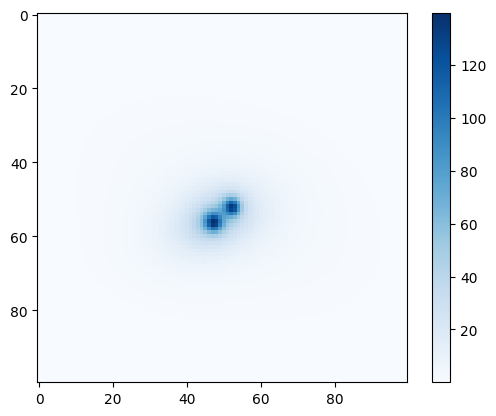

In [6]:
plt.imshow(fitter.getModelImage())
plt.colorbar();

In [83]:
models_n1 = galaxy_model(X0=starpos[0][0], Y0=starpos[0][1], X1=starpos[1][0], Y1=starpos[1][1], 
                                                 Xss0=starpos[0][0], Yss0=starpos[0][1], Xss1=starpos[1][0], Yss1=starpos[1][1],
                                                 Xlim=[0,100], Ylim=[0,100],
                                                 PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                                                 PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0,Imax], sigma_lim=[0,15],
                                      Iss_lim=[0,Imax], rss_lim=[0,100])

In [86]:
fitters_n1 = doFit(models_n1,epsf)

PsfOversampling: starting initialization...
141
PsfOversampling: done.


Fitting Models: 100%|█████████████████████████| 4/4 [04:46<00:00, 71.52s/it]

PsfOversampling: starting __dealloc__.
PsfOversampling: done with __dealloc__.


In [87]:
fitters_n1[1].getFitResult()

            aic: 899.5659012667114
            bic: 1000.468603379736
   fitConverged: True
        fitStat: 871.5238381720694
 fitStatReduced: 0.08727456821270473
          nIter: 71
      paramErrs: array([   0.0847244 ,    0.08294481, 1726.65615137,    6.29680167,
          0.07723568,    0.        ,    0.27355881,    3.32168542,
          0.07900672,    0.07318316, 2196.16196334,    2.13459697,
          0.02274605,    0.        ,    0.94394024,    0.47978968])
         params: array([   53.41393447,    53.52347348, 42547.23426351,   115.12426611,
           0.40998857,     1.        ,     1.36434195,    27.76585068,
          48.39928022,    57.67431332, 37715.22930055,   248.55401232,
           0.38279144,     1.        ,    15.83795437,    10.80560756])
     solverName: 'LM'

In [88]:
print(models_n1[1])

X0		56.0		0.0,100.0
Y0		52.0		0.0,100.0
FUNCTION PointSource   # LABEL psf
I_tot		19.537945703108253

FUNCTION Sersic   # LABEL bulge
PA		200.0		0.0,360.0
ell_bulge		0.1		0.0,1.0
n		1.0		fixed
I_e		1.0		0.0,135.13360595703125
r_e		20.0		0.0,100.0

X0		48.0		0.0,100.0
Y0		52.0		0.0,100.0
FUNCTION PointSource   # LABEL psf
I_tot		19.537945703108253

FUNCTION Sersic   # LABEL bulge
PA		200.0		0.0,360.0
ell_bulge		0.1		0.0,1.0
n		1.0		fixed
I_e		1.0		0.0,135.13360595703125
r_e		20.0		0.0,100.0

